In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from cycler import cycler
from mxlpy import Simulator, plot, make_protocol, Model, scan, mca, cartesian_product
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('..'))

from model import Saadat2021

here = Path("").absolute()

def save_fig(fig_num: str) -> Path:
    here = Path("").absolute()
    name = "Saadat2021"
    plt.savefig(here / f"{name.lower()}_fig{fig_num}.svg", format="svg", bbox_inches="tight")

## Str Dictionary

In [2]:
pfd_str = "PPFD"
flourescence_str = "Fluo"
kcyc_str = "kf_v_Cyc"
v_psi_str = "v_PSI"
v_psii_str = "v_PSII"
v_cyc_str = "v_Cyc"
v_mehler_str = "v_Mehler"
v_ptox_str = "v_PQ"
atp_rel_str = "ATP/tot"
nadph_rel_str = "NADPH/tot"
fd_rel_str = "Fd_ox/tot"
pq_rel_str = "PQ_ox/tot"
pc_rel_str = "PC_ox/tot"
h2o2_str = "H2O2"
vc_str = "v_RuBisCO_c"
psii_tot_str = "PSII_total"
psi_tot_str = "PSI_total"
kb6f_str = "kcat_v_b6f"
kMehler_str = "kMehler"
krubisco_str = "kcat_v_RuBisCO_c"
kfbpase_str = "kcat_v_FBPase"
ksbpase_str = "kcat_v_SBPase"
kmdareduct_str = "kcat_v_MDAreduct"
kdhar_str = "kcat_v_DHAR"
pqred_str = "PQH_2"
fdred_str = "Fd_red"
pcred_str = "PC_red"
nadph_str = "NADPH_st"
atp_str = "ATP_st"
rubp_str = "RUBP"
pga_str = "PGA"
fbp_str = "FBP"
sbp_str = "SBP"
vb6f_str = "v_b6f"
vMehler_str = "v_Mehler"
v_fbpase_str = "v_FBPase"
v_sbpase_str = "v_SBPase"
v_mdareduct_str = "v_MDAreduct"
v_dhar_str = "v_DHAR"

In [3]:
def calc_pam_vals2(
    fluo_result: pd.Series, protocol: pd.DataFrame, pfd_str: str, sat_pulse: float = 2000, do_relative: bool = False
) -> tuple[pd.Series, pd.Series]:
    """Calculate PAM values from fluorescence data.

    Use the fluorescence data from a PAM protocol to calculate Fm, NPQ. To find the Fm values, the protocol used for simulation is seperated into ranges between each saturating pulse. Then the maximum fluorescence value within each range is taken as Fm. Thes are then used to calculate NPQ.

    Args:
        fluo_result (pd.Series): Fluorescence data as a pd.Series from mxlpy simulation.
        protocol (pd.DataFrame): PAM protocol used for simulation. Created using make_protocol from mxlpy.
        pfd_str (str): The name of the PPFD parameter in the protocol.
        sat_pulse (float, optional): The threshold for saturating pulse in the protocol. Defaults to 2000.

    Returns:
        tuple[pd.Series, pd.Series]: Fm and NPQ as pd.Series
    """    
    
    F = fluo_result.copy()
    F.name = "Fluorescence"
    
    peaks = protocol[protocol[pfd_str] >= sat_pulse].copy()
    peaks.index = peaks.index.total_seconds()
    peaks = peaks.reset_index()
    
    Fm = {
        "start": [],
        "end": [],
        "time": [],
        "value": []
    }

    for idx, (time, _) in peaks.iterrows():
        if idx == 0:
            start_time = 0
        else:
            start_time = time - (time - peaks["Timedelta"].iloc[idx - 1]) / 2
            
        if idx == len(peaks) - 1:
            end_time = fluo_result.index[-1]
        else:
            end_time = time + (peaks["Timedelta"].iloc[idx + 1] - time) / 2
            
        Fm["start"].append(start_time)
        Fm["end"].append(end_time)
        Fm_slice = fluo_result.loc[start_time:end_time]
        Fm["time"].append(Fm_slice.idxmax())
        Fm["value"].append(Fm_slice.max())
        
    Fm = pd.DataFrame(Fm).set_index("time")
    Fm = Fm["value"]
    Fm.name = "Flourescence Peaks (Fm)"
    
    if do_relative:
        F = F / Fm.iloc[0]
        Fm = Fm / Fm.iloc[0]
    
    # Calculate NPQ
    NPQ = (Fm.iloc[0] - Fm) / Fm if len(Fm) > 0 else pd.Series(dtype=float)
    NPQ.name = "Non-Photochemical Quenching (NPQ)"
    
    return F, Fm, NPQ

# Figure 2

In [4]:

def create_fig2_sim(
    model: Model,
    pfd_str: str,
    kcyc_str: str,
):
    length_period = 120
    length_pulse = 0.8
    pulse_intensity = 5000
    dark_light = 40
    actinic_light = 1000
    
    length_nopulse = length_period - length_pulse

    dark_period = [
        (length_nopulse, {pfd_str: dark_light}),
        (length_pulse, {pfd_str: pulse_intensity}),
    ]
    light_period = [
        (length_nopulse, {pfd_str: actinic_light}),
        (length_pulse, {pfd_str: pulse_intensity}),
    ]

    prtc = dark_period * 2 + light_period * 10 + dark_period * 9
    
    pam_ptrc = make_protocol(prtc)
    
    s = Simulator(model)
    s.update_parameter(kcyc_str, 0)
    
    s.simulate_protocol(pam_ptrc)
    
    res = s.get_result().unwrap_or_err().get_combined()
    
    _, _, NPQ = calc_pam_vals2(
        fluo_result=res[flourescence_str],
        protocol=pam_ptrc,
        pfd_str=pfd_str,
        sat_pulse=pulse_intensity,
        do_relative=True,
    )
    
    return res, NPQ, pam_ptrc
    

def create_fig2_plot(
    res: pd.DataFrame,
    npq_res: pd.Series,
    pam_ptrc: pd.DataFrame,
    fluo_str: str,
    
):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(res[fluo_str] / max(res[fluo_str]), color="red", lw=2.5, label="Fluorescence")
    ax.plot(npq_res, linestyle="dashed", color="black", label="NPQ", lw=2)

    ax.legend(loc="upper right")

    pam_ptrc_cleaned = pam_ptrc[pam_ptrc[pfd_str] != 5000]
    prior = 0
    
    for idx, row in pam_ptrc_cleaned.iterrows():
        if row[pfd_str] == pam_ptrc_cleaned[pfd_str].max():
            prior = idx.total_seconds()
            continue
        
        ax.axvspan(
            xmin=prior,
            xmax=idx.total_seconds(),
            color="#b3b3b3ff",
        )
        prior = idx.total_seconds()

    ax.set(
        ylim=(0, 1.1),
        xlim=(0, 2500),
        xlabel="Time/(s)",
        ylabel="Fluorescence (normalised)",
    )
    
    return fig, ax

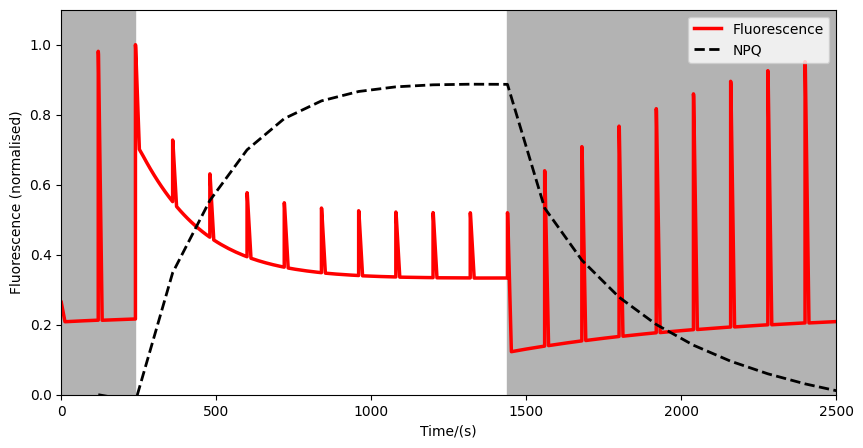

In [5]:

fig2_res_sim, fig2_res_npq, fig2_prtc = create_fig2_sim(
    model=Saadat2021(),
    pfd_str=pfd_str,
    kcyc_str=kcyc_str,
)

create_fig2_plot(
    res=fig2_res_sim,
    npq_res=fig2_res_npq,
    pam_ptrc=fig2_prtc,
    fluo_str=flourescence_str,
)

save_fig("2")

# Figure 3

In [6]:
def create_fig3_sim(
    model: Model,
    pfd_str: str,
):
    res = scan.steady_state(
        model=model,
        to_scan=pd.DataFrame({pfd_str: np.linspace(50, 1500, 500)})
    )
    res = pd.concat([res.variables, res.fluxes], axis=1)
    
    return res

def create_fig3_plot(
    res: pd.DataFrame,
    v_psi_str: str,
    v_psii_str: str,
    v_cyc_str: str,
    v_mehler_str: str,
    v_ptox_str: str,
    atp_rel_str: str,
    nadph_rel_str: str,
    fd_rel_str: str,
    pq_rel_str: str,
    pc_rel_str: str,
    h2o2_str: str,
):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    filtered_colors = [c for c in default_colors if c.lower() != "#d62728"]
    plt.rcParams["axes.prop_cycle"] = cycler(color=filtered_colors)

    for ax in axs:
        ax.set_xlabel(r"PPFD / (µmol $m^{-2}\ s^{-1})$")

    # FIGURE A

    axs[0].set_title("Photosynthetic Electron Fluxes")
    axs[0].text(-0.15, 1.05, "A", transform=axs[0].transAxes, size=15, weight="bold")
    secax = axs[0].twinx()

    left_plots = {
        "PSI": res[v_psi_str],
        "LEF": res[v_psii_str] * 2,
        "CEF": res[v_cyc_str],
        "Mehler": res[v_mehler_str],
        "PTOX": res[v_ptox_str]
    }

    for label, vals in left_plots.items():
        if label in ["Mehler", "PTOX"]:
            ax = secax
            color = "red"
            ls = "dashed" if label == "Mehler" else "dotted"
        else:
            ax = axs[0]
            color=None
            ls="solid"
        
        ax.plot(vals, label=label, lw=2, color=color, ls=ls)

    axs[0].set_ylabel("mmol e$^-$ / mol Chl / s")
    axs[0].legend(loc="upper left")
        
    secax.set_ylabel("mmol e$^-$ / mol Chl / s", color="red")
    secax.tick_params(axis="y", colors="red")
    secax.legend(loc="lower right")

    # FIGURE B

    axs[1].set_title("Energy and Redox Status")
    axs[1].text(-0.15, 1.05, "B", transform=axs[1].transAxes, size=15, weight="bold")
    secax = axs[1].twinx()

    right_plots = {
        "ATP": res[atp_rel_str],
        "NADPH": res[nadph_rel_str],
        "Fdred": res[fd_rel_str],
        "PQred": res[pq_rel_str],
        "PCred": res[pc_rel_str],
        "H2O2": res[h2o2_str]
    }

    for label, vals in right_plots.items():
        if label == "H2O2":
            ax = secax
            color = "red"
            ls = "dashed"
        else:
            ax = axs[1]
            color=None
            ls="solid"
            
        ax.plot(vals, label=label, color=color, ls=ls, lw=2)

    axs[1].set_ylabel("Fraction of the pool")
    axs[1].legend(loc="upper left")
    secax.set_ylabel("Concentration/mM", color="red")
    secax.tick_params(axis="y", colors="red")
    secax.legend(loc="lower right")

    plt.tight_layout()
    
    return fig, axs

 34%|███▍      | 170/500 [00:03<00:09, 36.42it/s][ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1757353025193/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 14.2788418906514 and h = 0.0854114003439783, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1757353025193/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 15.0145495084572 and h = 0.10652725717883, the corrector convergence test failed repeatedly or with |h| = hmin.
100%|██████████| 500/500 [00:11<00:00, 43.41it/s]


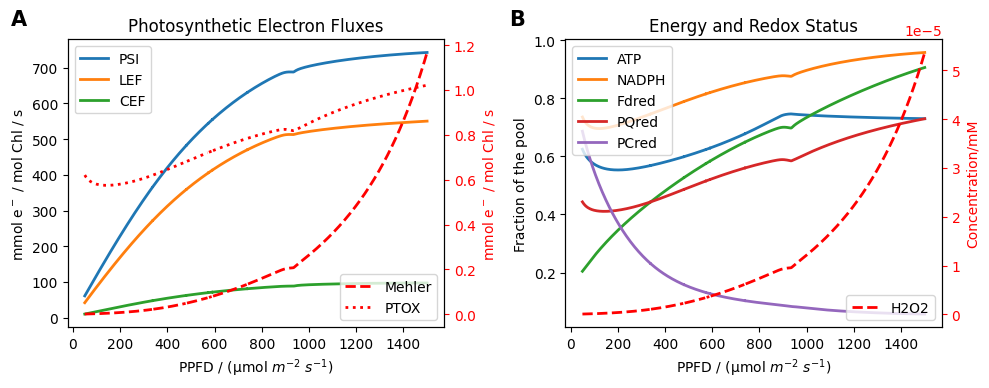

In [7]:
fig3_res = create_fig3_sim(
    model=Saadat2021(),
    pfd_str=pfd_str,
)

create_fig3_plot(
    res=fig3_res,
    v_psi_str=v_psi_str,
    v_psii_str=v_psii_str,
    v_cyc_str=v_cyc_str,
    v_mehler_str=v_mehler_str,
    v_ptox_str=v_ptox_str,
    atp_rel_str=atp_rel_str,
    nadph_rel_str=nadph_rel_str,
    fd_rel_str=fd_rel_str,
    pq_rel_str=pq_rel_str,
    pc_rel_str=pc_rel_str,
    h2o2_str=h2o2_str,
)

save_fig("3")

# Figure 4

In [8]:
def create_fig4_sim(
    model: Model,
    kcyc_str: str,
    pfd_str: str,
):
    model.update_parameter(pfd_str, 1000)
    
    res = scan.steady_state(
        model,
        to_scan=pd.DataFrame({kcyc_str: model.get_parameter_values()[kcyc_str] * (2 ** np.linspace(-3, 3, num=10))}),
    )
    
    return pd.concat([res.variables, res.fluxes], axis=1)

def create_fig4_plot(
    model: Model,
    res: pd.DataFrame,
    kcyc_str: str,
):
    fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)
    xvals = np.log2(res.index / model.get_parameter_values()[kcyc_str])

    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    filtered_colors = [c for c in default_colors if c.lower() != "#d62728"]
    plt.rcParams["axes.prop_cycle"] = cycler(color=filtered_colors)

    # FIGURE A

    axs[0].set_title("Photosynthetic Electron Fluxes")
    axs[0].text(-0.15, 1.05, "A", transform=axs[0].transAxes, size=15, weight="bold")

    secax = axs[0].twinx()

    secax.set_ylabel("H$_2$O$_2$ / µM", color="red")
    secax.tick_params(axis="y", colors="red")

    left_plots = {
        "PSI": res[v_psi_str],
        "LEF": res[v_psii_str] * 2,
        "CEF": res[v_cyc_str],
        "H2O2": res[h2o2_str]
    }

    for label, vals in left_plots.items():
        if label == "H2O2":
            ax = secax
            color = "red"
        else:
            ax = axs[0]
            color=None
        
        ax.plot(xvals, vals.values, label=label, lw=2, color=color)
        
    axs[0].set_ylabel("mmol e$^-$ / mol Chl / s")
    axs[0].legend(loc="upper left")
    secax.legend(loc="lower right")
        
    # FIGURE B

    axs[1].set_title("Energy and Redox Status")
    axs[1].text(-0.15, 1.05, "B", transform=axs[1].transAxes, size=15, weight="bold")

    right_plots = {
        "ATP": res[atp_rel_str],
        "NADPH": res[nadph_rel_str],
        "Fdred": res[fd_rel_str],
        "PQred": res[pq_rel_str],
        "PCred": res[pc_rel_str],
    }

    for label, vals in right_plots.items():
        axs[1].plot(xvals, vals.values, label=label, lw=2)
        
    axs[1].set_xlabel("log$_2$-fold change in PRG5 activity")
    axs[1].set_ylabel("Fraction of the pool")
    axs[1].legend(loc="upper left")

    plt.tight_layout()
    
    return fig, axs


100%|██████████| 10/10 [00:00<00:00, 15.39it/s]


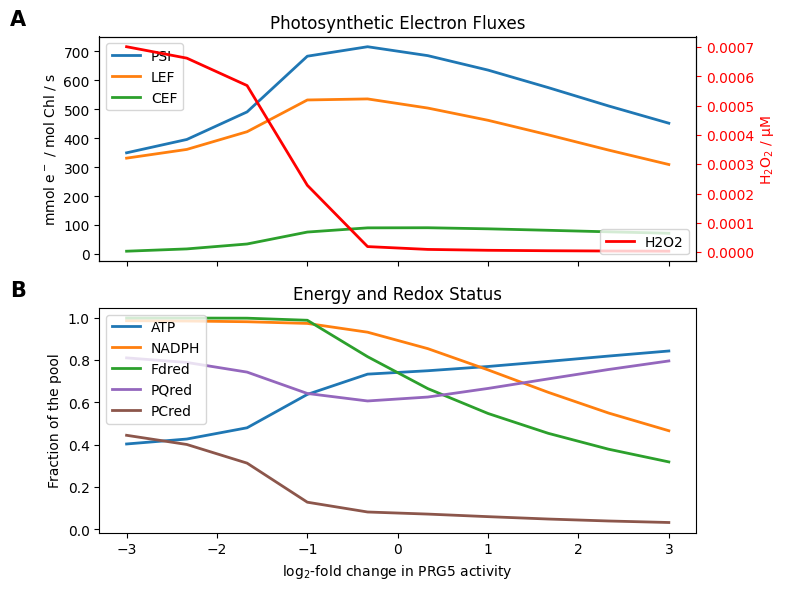

In [9]:
fig4_res = create_fig4_sim(
    model=Saadat2021(),
    kcyc_str=kcyc_str,
    pfd_str=pfd_str,
)

create_fig4_plot(
    model=Saadat2021(),
    res=fig4_res,
    kcyc_str=kcyc_str,
)

save_fig("4")

# Figure 5

In [10]:
def create_fig5_sim(
    model: Model,
    pfd_str: str,
    kcyc_str: str,
):
    ptrc = make_protocol([(60, {pfd_str: 600}), (60, {pfd_str: 40})] * 5)
    
    s = Simulator(model)
    s.simulate_protocol(ptrc)
    
    wt_res = s.get_result().unwrap_or_err().get_combined()
    
    s = Simulator(model)
    s.update_parameter(kcyc_str, 0)
    s.simulate_protocol(ptrc)
    ko_res = s.get_result().unwrap_or_err().get_combined()
    
    return wt_res, ko_res, ptrc

def create_fig5_plot(
    wt_res: pd.DataFrame,
    ko_res: pd.DataFrame,
    prtc: pd.DataFrame,
    fd_rel_str: str,
    vc_str: str,
    pfd_str: str,
):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    
    lw = 3
    axs[0].text(-0.15, 1.05, "A", transform=axs[0].transAxes, size=15, weight="bold")
    axs[0].plot(ko_res[fd_rel_str], label = "PGR-5 KO", lw=lw, color="red")
    axs[0].plot(wt_res[fd_rel_str], label = "wild type", lw=lw, color="black")
    
    axs[1].text(-0.15, 1.05, "B", transform=axs[1].transAxes, size=15, weight="bold")
    axs[1].plot(wt_res[vc_str], lw=lw, color="black")
    axs[1].plot(ko_res[vc_str], lw=lw, color="red")
    
    
    
    for ax in axs:
        ax.set_xlabel("Time / (s)")
        prior = 0
        for idx, row in prtc.iterrows():
            if row[pfd_str] == prtc[pfd_str].max():
                prior = idx.total_seconds()
                continue
            ax.axvspan(
                xmin=prior,
                xmax=idx.total_seconds(),
                color="#b3b3b3ff",
            )
            prior = idx.total_seconds()
    
    axs[0].set_ylabel("Fd Redox State")
    axs[1].set_ylabel("Rate of RuBisCO / (mM / s)")

    fig.legend(loc="lower center", ncols=2)

    plt.tight_layout(w_pad=2)
    
    return fig, axs

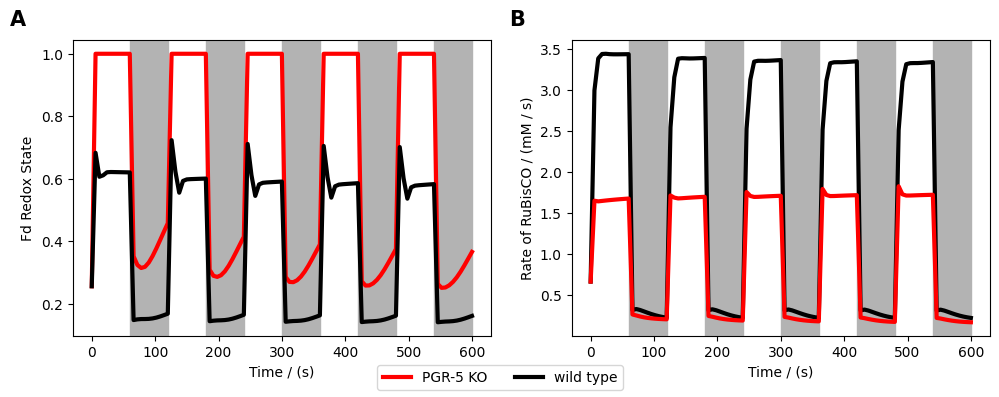

In [11]:
fig5_res_wt, fig5_res_ko, fig5_ptrc = create_fig5_sim(
    model=Saadat2021(),
    pfd_str=pfd_str,
    kcyc_str=kcyc_str,
)

create_fig5_plot(
    wt_res=fig5_res_wt,
    ko_res=fig5_res_ko,
    prtc=fig5_ptrc,
    fd_rel_str=fd_rel_str,
    vc_str=vc_str,
    pfd_str=pfd_str,
)

save_fig("5")

# Figure 6

In [12]:
def create_fig6_sim(
    model: Model,
    pfd_str: str,
    psii_tot_str: str,
    psi_tot_str: str,
    kb6f_str: str,
    kcyc_str: str,
    kMehler_str: str,
    krubisco_str: str,
    kfbpase_str: str,
    ksbpase_str: str,
    kmdareduct_str: str,
    kdhar_str: str,
):
    scan_params = {
        psii_tot_str: "PS2",
        psi_tot_str: "PS1",
        kb6f_str: "b$_6$f",
        kcyc_str: "PGR5",
        kMehler_str: "Mehler",
        krubisco_str: "RuBisCO",
        kfbpase_str: "FBPase",
        ksbpase_str: "SBPase",
        kmdareduct_str: "MDAR",
        kdhar_str: "DHAR"
    }
    
    res = {}
    
    for pfd_val in [100, 1000]:
        model.update_parameter(pfd_str, pfd_val)
        new_res = mca.response_coefficients(
                model,
                to_scan=scan_params.keys(),
                displacement=0.01
            )
        
        res[pfd_val] = pd.concat([new_res.variables, new_res.fluxes], axis=0)

    res = pd.concat(res, names=["PPFD"], axis=0)
    res = res.rename(columns=scan_params)
            
    return res

def create_fig6_plot(
    res: pd.DataFrame,
    pqred_str: str,
    fdred_str: str,
    pcred_str: str,
    nadph_str: str,
    atp_str: str,
    rubp_str: str,
    pga_str: str,
    fbp_str: str,
    sbp_str: str,
    v_psii_str: str,
    v_psi_str: str,
    vb6f_str: str,
    vMehler_str: str,
    v_cyc_str: str,
    vc_str: str,
    v_fbpase_str: str,
    v_sbpase_str: str,
    v_mdareduct_str: str,
    v_dhar_str: str,
):
    ppfd100 = res.loc[100]
    ppfd1000 = res.loc[1000]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
    
    new_vars_pointer = {
        pqred_str: r"PQ$_{\mathrm{red}}$",
        fdred_str: r"Fd$_{\mathrm{red}}$",
        pcred_str: r"PC$_{\mathrm{red}}$",
        nadph_str: "NADPH",
        atp_str: "ATP",
        rubp_str: "RUBP",
        pga_str: "PGA",
        fbp_str: "FBP",
        sbp_str: "SBP"
    }
    
    new_fluxes_pointer = {
        v_psii_str: "PS2",
        v_psi_str: "PS1",
        vb6f_str: "b$_6$f",
        vMehler_str: "Mehler",
        v_cyc_str: "CEF",
        vc_str: "RuBisCO",
        v_fbpase_str: "FBPase",
        v_sbpase_str: "SBPase",
        v_mdareduct_str: "MDAR",
        v_dhar_str: "DHAR"
    }
    
    for i, df in enumerate([ppfd1000, ppfd100]):
        
        df_fluxes = df.loc[new_fluxes_pointer.keys()].copy()
        df_fluxes = df_fluxes.rename(index=new_fluxes_pointer)
        
        df_vars = df.loc[new_vars_pointer.keys()].copy()
        df_vars = df_vars.rename(index=new_vars_pointer)
        
        plot.heatmap(df_fluxes, ax=axs[i, 0])
        plot.heatmap(df_vars, ax=axs[i, 1])

    for ax in axs.flat:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": 8})
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8, "ha": "center"})
        
    axs[0,0].set_title("Flux Control Coefficient")
    axs[0,1].set_title("Concentration Control Coefficient")

    fig.text(0.5, 1, r"PPFD = 1000 $\mathrm{\mu mol\ m^{-2}\ s^{-1}}$", ha="center", fontdict={"fontsize": 12})
    fig.text(0.5, 0.49, r"PPFD = 100 $\mathrm{\mu mol\ m^{-2}\ s^{-1}}$", ha="center", fontdict={"fontsize": 12})

    plt.tight_layout(h_pad=3)

100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


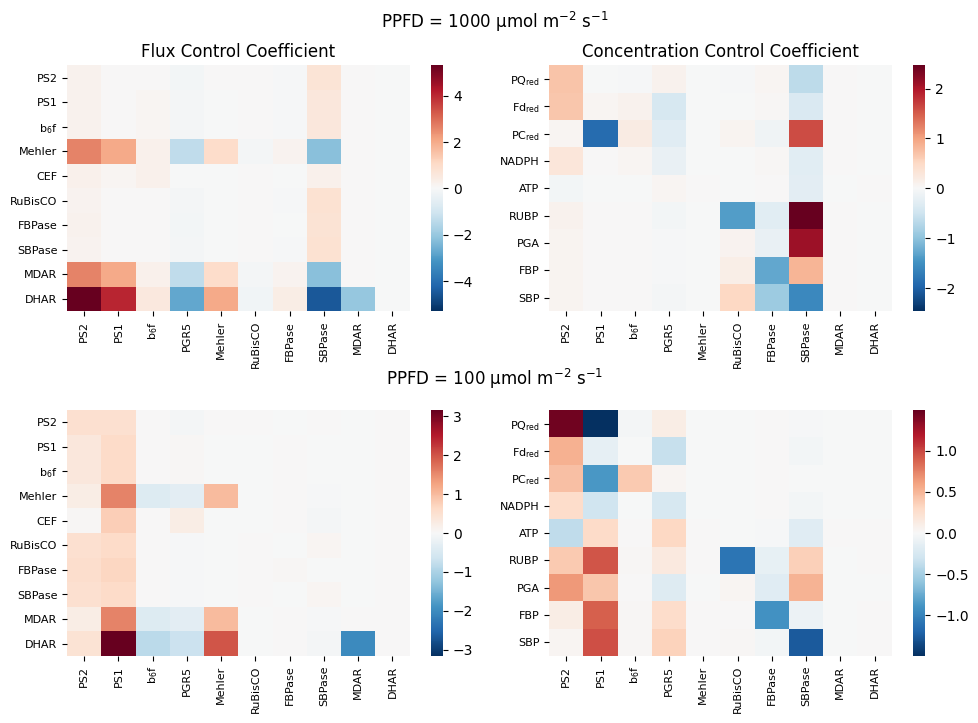

In [13]:
fig6_res = create_fig6_sim(
    model=Saadat2021(),
    pfd_str=pfd_str,
    psii_tot_str=psii_tot_str,
    psi_tot_str=psi_tot_str,
    kb6f_str=kb6f_str,
    kcyc_str=kcyc_str,
    kMehler_str=kMehler_str,
    krubisco_str=krubisco_str,
    kfbpase_str=kfbpase_str,
    ksbpase_str=ksbpase_str,
    kmdareduct_str=kmdareduct_str,
    kdhar_str=kdhar_str,
)

create_fig6_plot(
    res=fig6_res,
    pqred_str=pqred_str,
    fdred_str=fdred_str,
    pcred_str=pcred_str,
    nadph_str=nadph_str,
    atp_str=atp_str,
    rubp_str=rubp_str,
    pga_str=pga_str,
    fbp_str=fbp_str,
    sbp_str=sbp_str,
    v_psii_str=v_psii_str,
    v_psi_str=v_psi_str,
    vb6f_str=vb6f_str,
    vMehler_str=vMehler_str,
    v_cyc_str=v_cyc_str,
    vc_str=vc_str,
    v_fbpase_str=v_fbpase_str,
    v_sbpase_str=v_sbpase_str,
    v_mdareduct_str=v_mdareduct_str,
    v_dhar_str=v_dhar_str,
)

save_fig("6")

# Figure 7

In [14]:
def create_fig7_sim(
    model: Model,
    pfd_str: str,
    kcyc_str: str,
):
    
    num_params = 10
    
    scan.steady_state(
        model=model,
        to_scan=pd.DataFrame(cartesian_product({
            pfd_str: np.linspace(100, 1500, num_params),
            kcyc_str: model.get_parameter_values()[kcyc_str] * (2 ** np.linspace(-3, 3, num=num_params))
        }))
    )

In [ ]:
create_fig7_sim(
    model=Saadat2021(),
    pfd_str=pfd_str,
    kcyc_str=kcyc_str,
)

 43%|████▎     | 43/100 [15:46<46:25, 48.87s/it][ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1757353025193/work/sundials/src/cvodes/cvodes.c:8097][cvHandleFailure] At t = 113028.139977206 and h = 0.00143319530702902, the error test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1757353025193/work/sundials/src/cvodes/cvodes.c:8097][cvHandleFailure] At t = 1000000 and h = 1.94385542779333e-08, the error test failed repeatedly or with |h| = hmin.
 74%|███████▍  | 74/100 [1:20:16<44:04, 101.72s/it]